In [13]:
import requests
import json

from shapely.ops import linemerge
from shapely.geometry import LineString, Polygon, MultiPolygon

from geopandas import GeoDataFrame

import matplotlib.pyplot as plt

In [3]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name='Санкт-Петербург'];
(rel[admin_level='5'](area););
out geom meta;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
print(response)
data = response.json()

<Response [200]>


In [9]:
districts = []
for element in data['elements']:
    mline = []
    for member in element['members']:
        mline.append(LineString([(m['lon'], m['lat']) for m in member['geometry']]))
    mline = linemerge(mline)
    try:
        mline = Polygon(mline)
    except NotImplementedError:
        d = []
        for line in mline:
            d.append(Polygon(line))
        mline = MultiPolygon(d)
    districts.append((element['tags']['name'], mline))
    print(type(mline))

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>


In [12]:
gdf = GeoDataFrame(data=districts, columns=['name', 'geometry'])

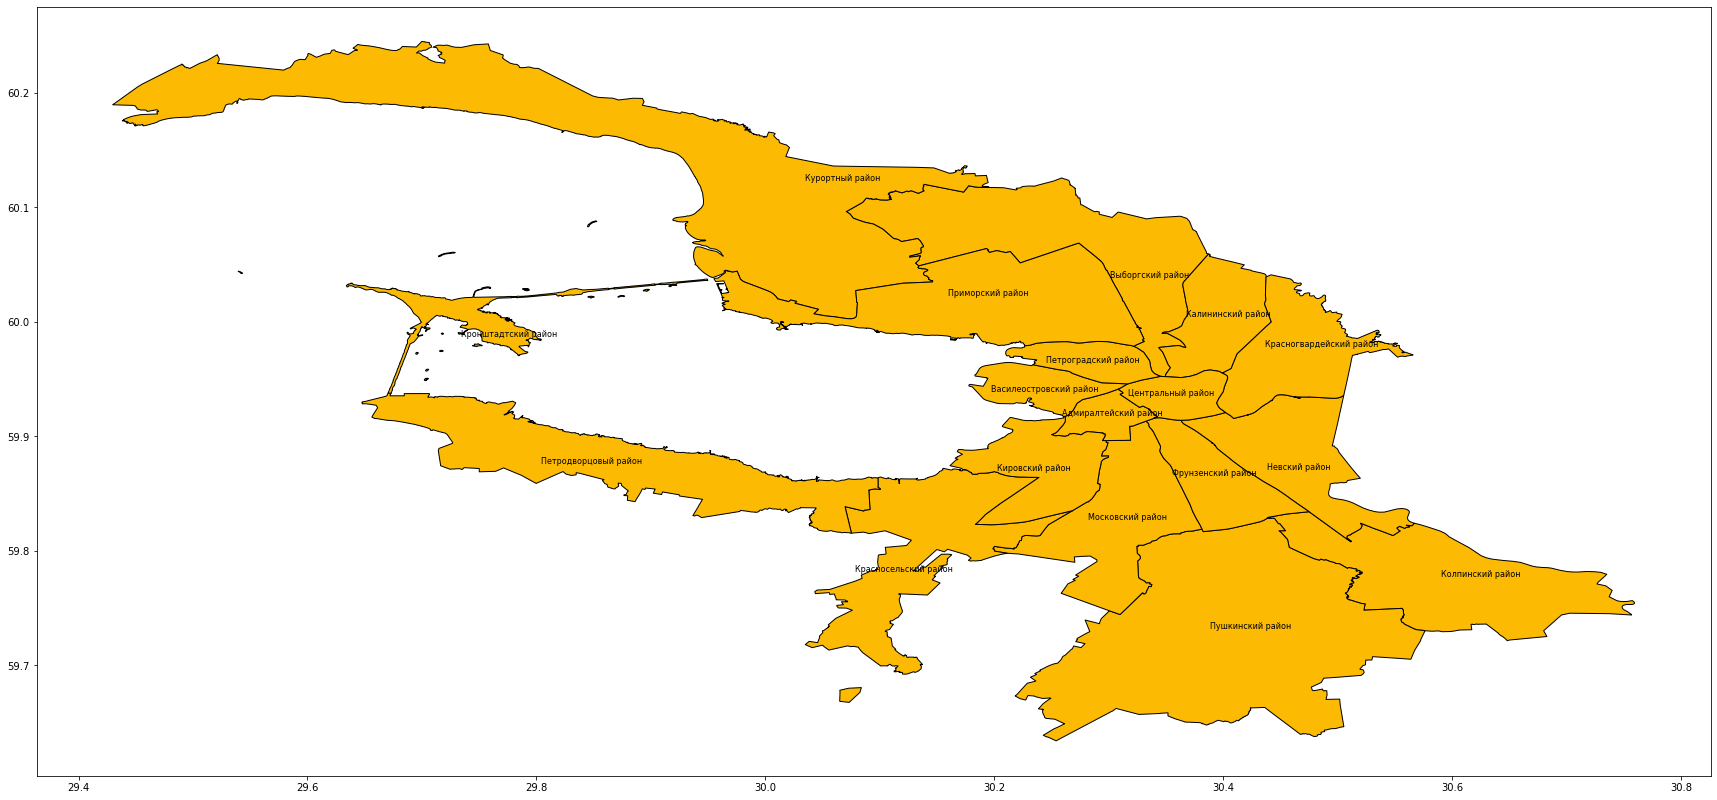

In [15]:
gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf['coords'] = [coords[0] for coords in gdf['coords']]
fig, ax = plt.subplots(figsize=(30,20))
gdf.plot(color='#fcba03', edgecolor='k', ax=ax)
for idx, row in gdf.iterrows():
    plt.annotate(s=row['name'], xy=row['coords'], horizontalalignment='center', fontsize=8)

In [162]:
gdf.to_csv('districts')